In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Global Variables

In [17]:
datasetsRootPath = './datasets'
samplesFolders = {'qualitas': 'qualitas', 'current': 'currentSample', 'updated': 'qualitasUpdated'}

In [18]:
def plotThresholdsCurve(graph, curve, metric, percentiles):
    graph.plot(curve['LOC_weights_norm'], curve[metric], color='black')
    for percentile in percentiles:
        per = curve[curve['LOC_weights_norm'] >= percentile][metric].values[0]
        graph.plot(np.interp(per, curve[metric], curve['LOC_weights_norm']), per, marker='o', markersize=5, color='black')
        graph.text(np.interp(per, curve[metric], curve['LOC_weights_norm']) + 0.02, per-0.4, f'{per}', color='black', weight='bold')
    graph.set_title(f'Thresholds {metric}', weight='bold')
    graph.set_xlabel('Quantiles')
    graph.set_ylim([1, curve[curve['LOC_weights_norm'] >= 0.95][metric].values[0]])
    
def plotSystemsDistribution(graph, entitiesAgg: pd.DataFrame, metric, painted=[]):
    projects = entitiesAgg['Repository'].unique()

    for project in projects:

        color = 'lightgrey'
        if project in painted:
            color = 'red'

        projectData = entitiesAgg[entitiesAgg['Repository'] == project]

        projectData = projectData.sort_values(by=metric)
        projectData['LOC_weights_cum'] = projectData['LOC_weights'].cumsum().to_frame()

        graph.plot(projectData['LOC_weights_cum'], projectData[metric], color=color)

    axis = entitiesAgg.groupby(metric)['LOC_weights_norm'].sum().to_frame()

    axis['cdf'] = axis['LOC_weights_norm'].cumsum()

    graph.plot(axis['cdf'], axis.index, color='black')
    
    graph.set_title(f'Systems Thresholds ({metric})', weight='bold')
    graph.set_xlabel('Quantiles')
    graph.set_ylim([1, axis[axis['cdf'] >= 0.99].index.values[0]])

In [19]:
def generateAlvesThresholds(df, metric):
    # 1. Metrics Extraction
    total_loc = df.groupby('Repository')['LOC'].sum()
    df = df.join(total_loc, on='Repository', rsuffix='_total')

    # 2. Weight Ratio Calculation
    df['LOC_weights'] = df['LOC'] / (df['LOC_total'])

    # 3. Entity aggregation
    entitiesAgg = df.groupby(['Repository', metric])['LOC_weights'].sum().reset_index()

    # 4. System aggregation
    systems = total_loc.shape[0]
    entitiesAgg['LOC_weights_norm'] = entitiesAgg['LOC_weights']/systems
    systemAgg = entitiesAgg.groupby(metric)['LOC_weights_norm'].sum().reset_index()
    axis = systemAgg.copy()

    # 5. Weight Ratio Aggregation
    systemAgg = systemAgg.sort_values(by=metric)
    axis['LOC_weights_norm'] = systemAgg['LOC_weights_norm'].cumsum().to_frame()

    # 6. Thresholds derivaton
    p70 = axis[axis['LOC_weights_norm'] >= 0.7][metric].values[0]
    p80 = axis[axis['LOC_weights_norm'] >= 0.8][metric].values[0]
    p90 = axis[axis['LOC_weights_norm'] >= 0.9][metric].values[0]

    metricRow = pd.DataFrame([{'Metric': metric, '70th': p70, '80th': p80, '90th':p90}])
    return metricRow, axis, entitiesAgg

In [20]:
def systemsThresholds(entitiesAgg, metric):
    thresholds = pd.DataFrame()
    projects = entitiesAgg['Repository'].unique()
    
    for id in range(len(projects)):
        systemValues = entitiesAgg[entitiesAgg['Repository'] == projects[id]].copy()
        systemValues = systemValues.sort_values(by=metric)
        systemValues['LOC_weights_cum'] = systemValues['LOC_weights'].cumsum().to_frame()

        p70 = systemValues[systemValues['LOC_weights_cum'] >= 0.70][metric].values[0]
        p80 = systemValues[systemValues['LOC_weights_cum'] >= 0.80][metric].values[0]
        p90 = systemValues[systemValues['LOC_weights_cum'] >= 0.90][metric].values[0]
        systemThresholds = pd.DataFrame([{'System': projects[id], '70th': p70, '80th': p80, '90th': p90}])
        thresholds = pd.concat([thresholds, systemThresholds])
    
    return thresholds

# Threshold Derivation (Section 4.2.1)

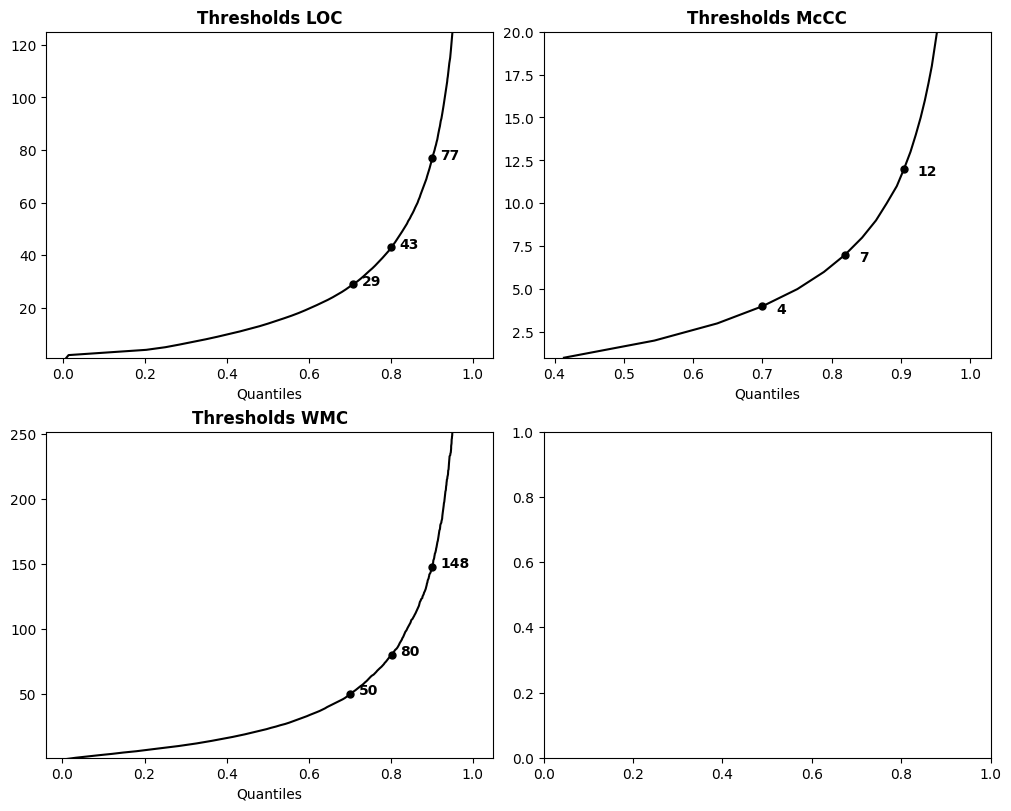

Number of projects: 112


Metric 70th 80th 90th
0    LOC   29   43   77
0   McCC    4    7   12
0    WMC   50   80  148

In [21]:
datasetPath = f'{datasetsRootPath}/{samplesFolders["current"]}'
metrics = {'method': ['LOC', 'McCC'], 'class': ['WMC']}
metricCount = 0
for level in metrics:
    metricCount += len(metrics[level])

datasets = {}
results = pd.DataFrame(columns=['Metric', '70th', '80th', '90th'])
fig, axs = plt.subplots(2,2, figsize=(10, 4*2), constrained_layout = True)
i=0
j=0

for level in metrics:
    dataset = pd.read_csv(f'{datasetPath}/{level}.csv')
    datasets[level] = dataset

    for metric in metrics[level]:
        thresholds, curves, _ = generateAlvesThresholds(datasets[level], metric)
        plotThresholdsCurve(axs[i,j], curves, metric, [0.7, 0.8, 0.9])
        j+=1
        results = pd.concat([results, thresholds]) 
    j=0 
    i+=1      
        
plt.show()
print(f'Number of projects: {datasets["class"]["Repository"].nunique()}')
results

# Outlier detection (Section 4.2.2)


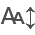

LOC


System  \
0                        https://github.com/aliyun/aliyun-openapi-java-sdk   
0                             https://github.com/FluentLenium/FluentLenium   
0                               https://github.com/yurake/k8s-3tier-webapp   
0                                 https://github.com/apache/shardingsphere   
0                           https://github.com/testingisdocumenting/webtau   
0                                        https://github.com/kbss-cvut/jopa   
0                        https://github.com/spring-projects/spring-session   
0                      https://github.com/spring-cloud/spring-cloud-sleuth   
0                                   https://github.com/eclipse-ditto/ditto   
0                 https://github.com/micronaut-projects/micronaut-security   
0                    https://github.com/TencentCloud/tencentcloud-sdk-java   
0                         https://github.com/codecentric/spring-boot-admin   
0                             https://github.com/prebid/prebid-server-java   
0                                  https://github.com/cloudfoundry/credhub   
0                                    https://github.com/OWASP/wrongsecrets   
0                           https://github.com/mybatis/spring-boot-starter   
0                              https://github.com/kitodo/kitodo-production   
0                                    https://github.com/dropwizard/metrics   
0                               https://github.com/jshiell/checkstyle-idea   
0                                        https://github.com/RIPE-NCC/whois   
0                          https://github.com/newrelic/newrelic-java-agent   
0                           https://github.com/microstream-one/microstream   
0                              https://github.com/googleapis/java-bigtable   
0                          https://github.com/camunda/camunda-bpm-platform   
0                                     https://github.com/apple/servicetalk   
0                               https://github.com/openedx/edx-app-android   
0                             https://github.com/graphql-java/graphql-java   
0                                   https://github.com/freeplane/freeplane   
0                     https://github.com/open-telemetry/opentelemetry-java   
0                                  https://github.com/membrane/api-gateway   
0                                             https://github.com/jpos/jPOS   
0                         https://github.com/MinecraftForge/MinecraftForge   
0                                 https://github.com/pinpoint-apm/pinpoint   
0                           https://github.com/Azure/azure-sdk-for-android   
0                             https://github.com/Tslat/Advent-Of-Ascension   
0                                           https://github.com/google/auto   
0                                           https://github.com/vaadin/flow   
0                                  https://github.com/powsybl/powsybl-core   
0                         https://github.com/firebase/firebase-android-sdk   
0                      https://github.com/stefan-niedermann/nextcloud-deck   
0                     https://github.com/micronaut-projects/micronaut-data   
0                           https://github.com/bonigarcia/webdrivermanager   
0                       https://github.com/deku-messaging/Deku-SMS-Android   
0                  https://github.com/apache/incubator-kie-kogito-runtimes   
0                                          https://github.com/google/truth   
0                                        https://github.com/dromara/MaxKey   
0                                 https://github.com/javaparser/javaparser   
0                                           https://github.com/apache/hudi   
0                        https://github.com/jenkinsci/opentelemetry-plugin   
0                           https://github.com/inception-project/inception   
0                            https://github.com/FasterXML/jackson-databind   
0           

McCC


System  \
0                        https://github.com/aliyun/aliyun-openapi-java-sdk   
0                        https://github.com/spring-projects/spring-session   
0                             https://github.com/FluentLenium/FluentLenium   
0                                   https://github.com/eclipse-ditto/ditto   
0                         https://github.com/codecentric/spring-boot-admin   
0                           https://github.com/testingisdocumenting/webtau   
0                               https://github.com/yurake/k8s-3tier-webapp   
0  https://github.com/AzureAD/microsoft-authentication-library-for-android   
0                                        https://github.com/kbss-cvut/jopa   
0                      https://github.com/spring-cloud/spring-cloud-sleuth   
0                           https://github.com/microstream-one/microstream   
0                                 https://github.com/Zoinkwiz/quest-helper   
0                 https://github.com/micronaut-projects/micronaut-security   
0                                    https://github.com/OWASP/wrongsecrets   
0                                 https://github.com/apache/shardingsphere   
0                                  https://github.com/cloudfoundry/credhub   
0                                    https://github.com/dropwizard/metrics   
0                             https://github.com/prebid/prebid-server-java   
0                          https://github.com/camunda/camunda-bpm-platform   
0                         https://github.com/firebase/firebase-android-sdk   
0                     https://github.com/open-telemetry/opentelemetry-java   
0                                  https://github.com/powsybl/powsybl-core   
0                      https://github.com/stefan-niedermann/nextcloud-deck   
0                                  https://github.com/projectnessie/nessie   
0                                       https://github.com/seart-group/ghs   
0                                        https://github.com/RIPE-NCC/whois   
0                               https://github.com/jshiell/checkstyle-idea   
0                                           https://github.com/vaadin/flow   
0                           https://github.com/mybatis/spring-boot-starter   
0                              https://github.com/googleapis/java-bigtable   
0                             https://github.com/graphql-java/graphql-java   
0                         https://github.com/MinecraftForge/MinecraftForge   
0                                     https://github.com/apple/servicetalk   
0                                 https://github.com/metasfresh/metasfresh   
0                          https://github.com/SonarOpenCommunity/sonar-cxx   
0                       https://github.com/deku-messaging/Deku-SMS-Android   
0                                           https://github.com/google/auto   
0                              https://github.com/kitodo/kitodo-production   
0                     https://github.com/micronaut-projects/micronaut-data   
0                                        https://github.com/dromara/MaxKey   
0                           https://github.com/inception-project/inception   
0                          https://github.com/newrelic/newrelic-java-agent   
0                               https://github.com/openedx/edx-app-android   
0                                          https://github.com/apache/druid   
0                                 https://github.com/mozilla/gcp-ingestion   
0                                           https://github.com/apache/hudi   
0                                   https://github.com/freeplane/freeplane   
0                                        https://github.com/getodk/collect   
0                        https://github.com/jenkinsci/opentelemetry-plugin   
0                                       https://github.com/DaFuqs/Spectrum   
0                           https://github.com/bonigarcia/webdrivermanager   
0           

WMC


System  \
0                               https://github.com/yurake/k8s-3tier-webapp   
0                                  https://github.com/cloudfoundry/credhub   
0                         https://github.com/codecentric/spring-boot-admin   
0                                    https://github.com/OWASP/wrongsecrets   
0                 https://github.com/micronaut-projects/micronaut-security   
0                                    https://github.com/dropwizard/metrics   
0                                       https://github.com/seart-group/ghs   
0                        https://github.com/spring-projects/spring-session   
0                                 https://github.com/Zoinkwiz/quest-helper   
0                     https://github.com/open-telemetry/opentelemetry-java   
0                        https://github.com/aliyun/aliyun-openapi-java-sdk   
0                               https://github.com/jshiell/checkstyle-idea   
0                      https://github.com/spring-cloud/spring-cloud-sleuth   
0                             https://github.com/FluentLenium/FluentLenium   
0                                   https://github.com/eclipse-ditto/ditto   
0                                 https://github.com/mozilla/gcp-ingestion   
0                                          https://github.com/EBISPOT/ols4   
0                        https://github.com/jenkinsci/opentelemetry-plugin   
0                                        https://github.com/dromara/MaxKey   
0                           https://github.com/mybatis/spring-boot-starter   
0                       https://github.com/deku-messaging/Deku-SMS-Android   
0                                      https://github.com/maxcom/lorsource   
0                                      https://github.com/apache/seatunnel   
0                           https://github.com/testingisdocumenting/webtau   
0                                        https://github.com/kbss-cvut/jopa   
0                                        https://github.com/RIPE-NCC/whois   
0                                           https://github.com/google/auto   
0                             https://github.com/Tslat/Advent-Of-Ascension   
0                    https://github.com/TencentCloud/tencentcloud-sdk-java   
0                         https://github.com/MinecraftForge/MinecraftForge   
0                                  https://github.com/projectnessie/nessie   
0                                    https://github.com/Mahmud0808/Iconify   
0                      https://github.com/stefan-niedermann/nextcloud-deck   
0                                          https://github.com/apache/druid   
0                           https://github.com/ControlSystemStudio/phoebus   
0                                  https://github.com/membrane/api-gateway   
0                                       https://github.com/DaFuqs/Spectrum   
0                          https://github.com/newrelic/newrelic-java-agent   
0                           https://github.com/inception-project/inception   
0                                   https://github.com/jreleaser/jreleaser   
0                                    https://github.com/VazkiiMods/Botania   
0                                 https://github.com/pinpoint-apm/pinpoint   
0                          https://github.com/SonarOpenCommunity/sonar-cxx   
0                                 https://github.com/primefaces/primefaces   
0                         https://github.com/firebase/firebase-android-sdk   
0                                        https://github.com/getodk/collect   
0                             https://github.com/graphql-java/graphql-java   
0                                           https://github.com/apache/hudi   
0                            https://github.com/GAIGResearch/TabletopGames   
0                                 https://github.com/BetonQuest/BetonQuest   
0                                  https://github.com/powsybl/powsybl-core   
0           

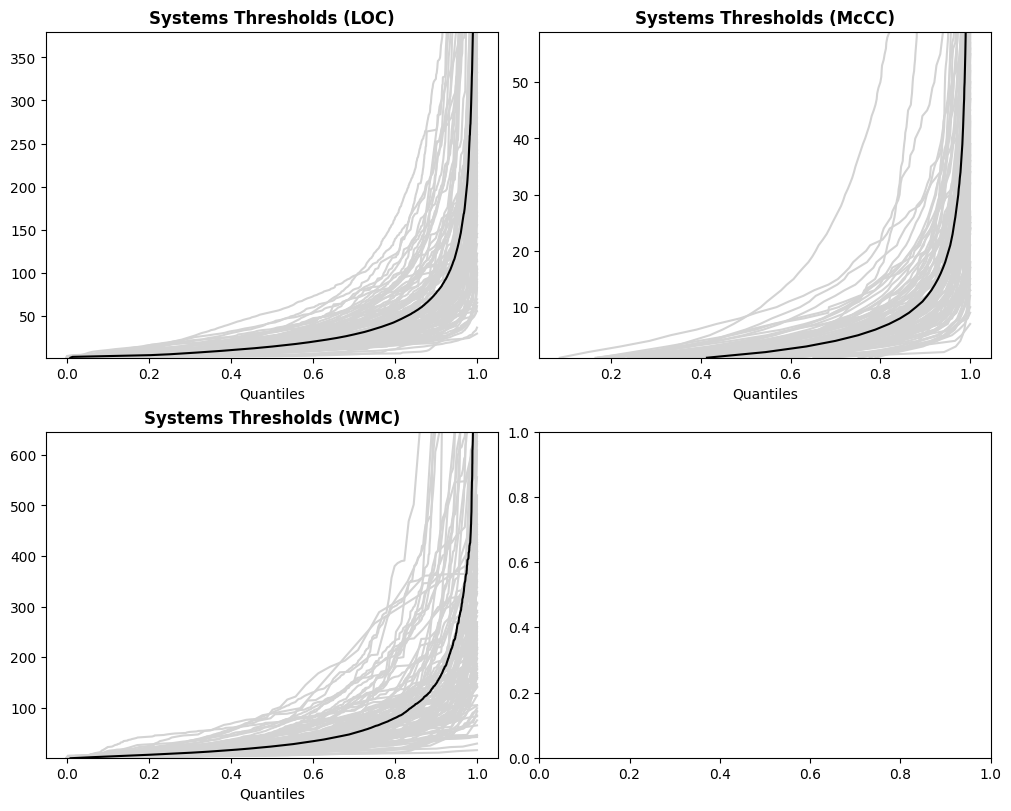

In [22]:
from scipy.spatial.distance import jensenshannon
from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)
outliers = []#'https://github.com/eclipse/xtext', 'https://github.com/SemanticApplicationDesignLanguage/sadl']

fig, axs = plt.subplots(2,2, figsize=(10, 4*2), constrained_layout = True)
i=0
j=0

for level in metrics:
    for metric in metrics[level]:
        _, _, entitiesAgg = generateAlvesThresholds(datasets[level], metric)
        results = systemsThresholds(entitiesAgg, metric)
        results = results.sort_values(by=['90th', '80th', '70th'])


        for id, project in results.iterrows():
            projectProbDist = entitiesAgg[entitiesAgg['Repository'] == project['System']].reset_index()[[metric, 'LOC_weights']]
            datasetProbDist = entitiesAgg.groupby(metric)['LOC_weights_norm'].sum().reset_index()[[metric, 'LOC_weights_norm']]           
        
            dfs = pd.merge(projectProbDist, datasetProbDist, on=metric, how='outer')[[metric, 'LOC_weights', 'LOC_weights_norm']]
            dfs.rename(columns={'LOC_weights': 'outlier', 'LOC_weights_norm': "sample"}, inplace=True)
            dfs.fillna(0, inplace=True)

            dfs = dfs.sort_values(metric)

            

        print(metric)
        with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
            display(results) 

        plotSystemsDistribution(axs[i,j], entitiesAgg, metric, outliers)
        j+=1

    j=0
    i+=1

plt.show()

## Replace Outliers

In [25]:
from main import replaceOutliers

# Dataset with all the projects in the sampling frame
population = pd.read_csv(f'{datasetsRootPath}/frame.csv')


replaceOutliers(population, datasetPath, outliers, './SourceMeter', './SourceMeter/repos')

Define the repositories to replace


# Data Analysis (Section 4.3)

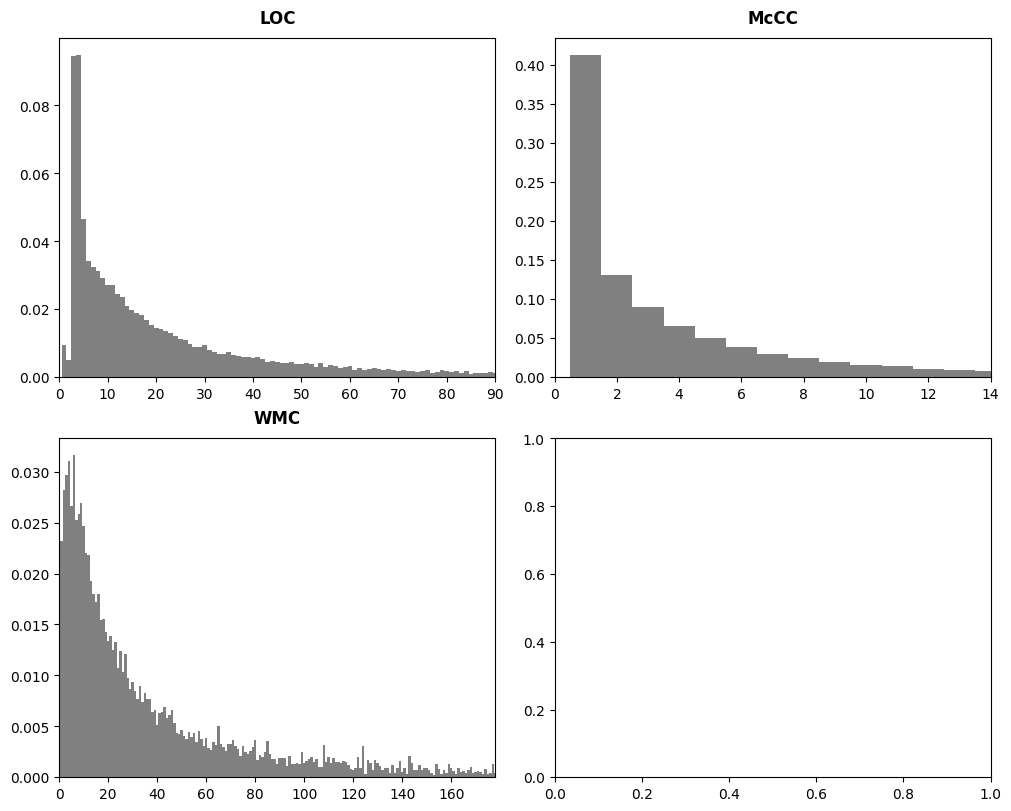

In [26]:
descStats = pd.DataFrame()
methodDim = ['LOC', 'McCC']
classDim = ['WMC']
metricTitles = ["LOC", "McCC", "WMC"]
folder = samplesFolders['current']

fig, axs = plt.subplots(2, 2, figsize=(10, 8), constrained_layout = True)

classSample = pd.read_csv(f'{datasetsRootPath}/{folder}/class.csv')
methodSample = pd.read_csv(f'{datasetsRootPath}/{folder}/method.csv')

def plotting(dimensions, sample, i):
    j = 0
    for dimension in dimensions:

        _, _, agg = generateAlvesThresholds(sample, dimension)
        sys = agg.groupby(dimension)['LOC_weights_norm'].sum().reset_index()[[dimension, 'LOC_weights_norm']]

        dfs = sys.sort_values(dimension)
        dfs['cdf'] = dfs['LOC_weights_norm'].cumsum()
        lim = dfs[dfs['cdf'] >= 0.92][dimension].values[0]
        axs[i,j].set_xlim((0, lim))
        axs[i, j].set_title(dimension, weight="bold", y=1.02)

        axs[i,j].bar(dfs[dimension], dfs['LOC_weights_norm'], width=1, color='grey')

        j += 1  

plotting(methodDim, methodSample, 0)
plotting(classDim, classSample, 1)


# Results (Section 5)

C:\Users\juancarruthers\AppData\Local\Temp\ipykernel_16008\2979926625.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  qcTable = pd.concat([qcTable, pd.DataFrame([[metric, qc["ks-statistic"], qc["p-value"]]], columns=tableColumns)])
C:\Users\juancarruthers\AppData\Local\Temp\ipykernel_16008\2979926625.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  qucTable = pd.concat([qucTable, pd.DataFrame([[metric, quc["ks-statistic"], quc["p-value"]]], columns=tableColumns)])
C:\Users\juancarruther


Q and C Comparison


metric  KS-statistic       P-value
0    LOC      0.129592  1.370487e-07
0   McCC      0.127219  8.362740e-03
0    WMC      0.133185  2.204186e-07


Qu and C Comparison


metric  KS-statistic   P-value
0    LOC      0.020408  0.986933
0   McCC      0.011834  1.000000
0    WMC      0.011099  1.000000

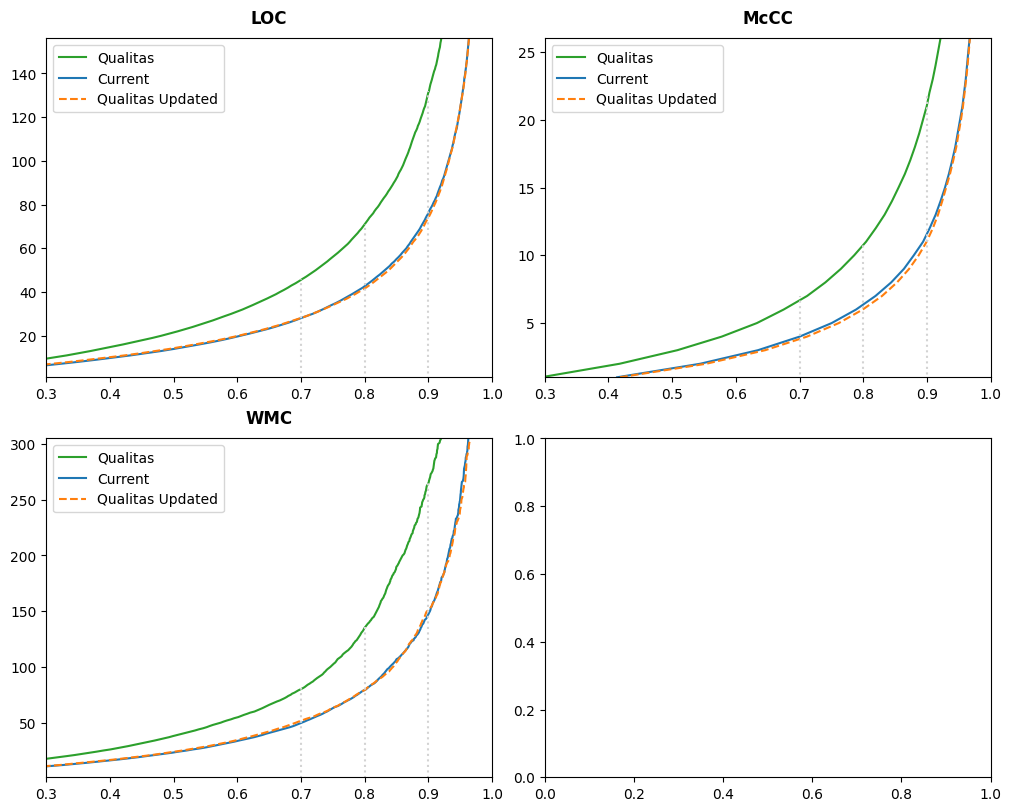

In [27]:
from ks2sampCDF import ks_2sampCDF

methodDim = ['LOC', 'McCC']
classDim = ['WMC']
metricTitles = ["LOC", "McCC", "WMC"]

legends = ['Qualitas', 'Current', 'Qualitas Updated']
lineStyles = ['-', '-', '--']
lineColors = ['#2ca02c', '#1f77b4', '#ff7f0e']
classSamples = []
methodSamples = []
dims = len(methodDim) + len(classDim)
tableColumns = ['metric', 'KS-statistic', 'P-value']
qcTable = pd.DataFrame(columns=tableColumns)
qucTable = pd.DataFrame(columns=tableColumns)

fig, axs = plt.subplots(2, 2, figsize=(10, 8), constrained_layout = True)


for sample in samplesFolders.values():
    classSample = pd.read_csv(f'{datasetsRootPath}/{sample}/class.csv')
    classSamples.append(classSample)

    methodSample = pd.read_csv(f'{datasetsRootPath}/{sample}/method.csv')
    methodSamples.append(methodSample)


def plotting(dimensions, typeSamples, i):
    global qcTable
    global qucTable

    k=0
    for metric in dimensions:

        thresholds = []
        nSamples = len(samplesFolders)
        folders = list(samplesFolders.values())

        for j in range(nSamples):
            
            _, _, agg = generateAlvesThresholds(typeSamples[j], metric)
            sys = agg.groupby(metric)['LOC_weights_norm'].sum().reset_index()[[metric, 'LOC_weights_norm']]
            sys.rename(columns={'LOC_weights_norm': folders[j]}, inplace=True)
            thresholds.append(sys)


        dfs = pd.merge(thresholds[0], thresholds[1], on=metric, how='outer')
        dfs = pd.merge(dfs, thresholds[2], on=metric, how='outer')
        dfs.fillna(0, inplace=True)

        dfs = dfs.sort_values(metric)

        for j in range(nSamples):

            dfs[f'cdf_{folders[j]}'] = dfs[folders[j]].cumsum()
            axs[i, k].plot(dfs[f'cdf_{folders[j]}'], dfs[metric], linestyle=lineStyles[j], color=lineColors[j])

        axs[i, k].legend(legends)

        lim = dfs[dfs['cdf_qualitas'] >= 0.92][metric].values[0]

        axs[i, k].set_ylim(1, lim)
        axs[i, k].set_xlim(0.3, 1)

        axs[i, k].set_title(metricTitles[i*2 + k], weight="bold", y=1.02)
        axs[i, k].plot([0.7, 0.7], [0, dfs[dfs['cdf_qualitas'] >= 0.7][metric].values[0]], linestyle=':', color= 'lightgrey')
        axs[i, k].plot([0.8, 0.8], [0, dfs[dfs['cdf_qualitas'] >= 0.8][metric].values[0]], linestyle=':', color= 'lightgrey')
        axs[i, k].plot([0.9, 0.9], [0, dfs[dfs['cdf_qualitas'] >= 0.9][metric].values[0]], linestyle=':', color= 'lightgrey')

        k+=1

        qc = ks_2sampCDF(dfs[f"cdf_{samplesFolders['qualitas']}"], dfs[f"cdf_{samplesFolders['current']}"], method="exact")
        quc = ks_2sampCDF(dfs[f"cdf_{samplesFolders['updated']}"], dfs[f"cdf_{samplesFolders['current']}"], method="exact")

        qcTable = pd.concat([qcTable, pd.DataFrame([[metric, qc["ks-statistic"], qc["p-value"]]], columns=tableColumns)])
        qucTable = pd.concat([qucTable, pd.DataFrame([[metric, quc["ks-statistic"], quc["p-value"]]], columns=tableColumns)])    

plotting(methodDim, methodSamples, 0)
plotting(classDim, classSamples, 1)

print("\nQ and C Comparison")
display(qcTable)
print("\nQu and C Comparison")
display(qucTable)

plt.show()
